In [1]:
# —————————————
# 4c. LSTM (Deep Learning)
# —————————————

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error


Epoch 1/10


/opt/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1971/1971 - 36s - 18ms/step - loss: 0.0031 - val_loss: 7.5075e-04
Epoch 2/10
1971/1971 - 35s - 18ms/step - loss: 0.0011 - val_loss: 4.1956e-04
Epoch 3/10
1971/1971 - 36s - 18ms/step - loss: 7.2777e-04 - val_loss: 4.0866e-04
Epoch 4/10
1971/1971 - 35s - 18ms/step - loss: 6.3447e-04 - val_loss: 3.6026e-04
Epoch 5/10
1971/1971 - 36s - 18ms/step - loss: 6.0779e-04 - val_loss: 3.5281e-04
Epoch 6/10
1971/1971 - 37s - 19ms/step - loss: 5.9601e-04 - val_loss: 3.5203e-04
Epoch 7/10
1971/1971 - 36s - 18ms/step - loss: 5.8399e-04 - val_loss: 3.5184e-04
Epoch 8/10
1971/1971 - 35s - 18ms/step - loss: 5.7723e-04 - val_loss: 3.4348e-04
Epoch 9/10
1971/1971 - 36s - 18ms/step - loss: 5.7465e-04 - val_loss: 3.4850e-04
Epoch 10/10
1971/1971 - 37s - 19ms/step - loss: 5.6701e-04 - val_loss: 3.5720e-04
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
LSTM → RMSE: 30965.71, MAE: 21113.87, MAPE: 1.20%


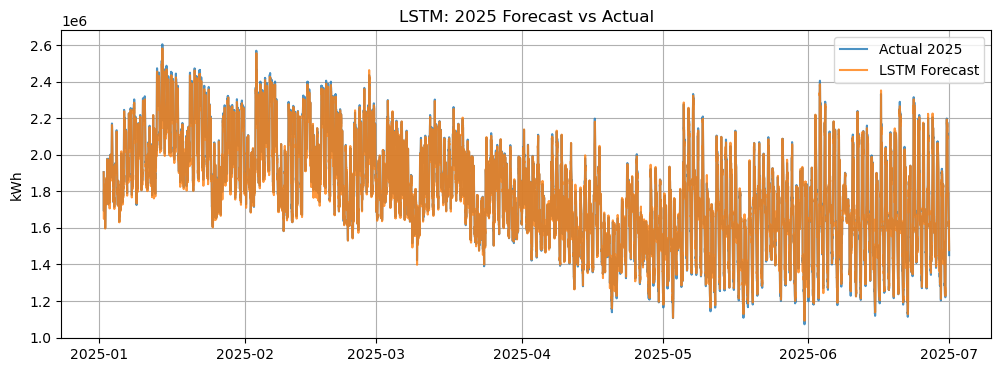

In [ ]:


# —————————————
# Load feature matrix and split by date (train: ≤2024-12-31, test: 2025-01-01 onward)
# —————————————

feat_path = Path("../data/processed/electricity_features_15min.csv")
df = pd.read_csv(feat_path, parse_dates=['datetime'], index_col='datetime')
train = df.loc[: "2024-12-31 23:45"]
test  = df.loc["2025-01-01":]

# —————————————
# Scale target Variable
# —————————————

scaler = MinMaxScaler()
train_vals = scaler.fit_transform(train[['total_consumption_kWh']])
test_vals  = scaler.transform(test [['total_consumption_kWh']])

# —————————————
# Create Sequence of LSTM
# —————————————

def create_sequences(data, seq_len=96):
    X,y = [],[]
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i,0])
        y.append(data[i,0])
    return np.array(X), np.array(y)

seq_len=96

X_train, y_train = create_sequences(train_vals, seq_len)
X_test, y_test = create_sequences(test_vals,seq_len )


# —————————————
#Reshape
# —————————————


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# —————————————
# Build LSTM
# —————————————


model = Sequential([
    LSTM(64, input_shape=(seq_len, 1 ), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# —————————————
# Train Model
# —————————————

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)

# —————————————
# Forcasting
# —————————————

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).ravel()
y_true = test['total_consumption_kWh'].iloc[seq_len:].values


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

print(f"LSTM → RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")



metric_lstm = {
    "RMSE" : rmse,
    "MAE" : mae,
    "MAPE" : mape
}


print(f"LSTM metrics: {metric_lstm}")

test_idx = test.index[seq_len:]
plt.figure(figsize=(12,4))
plt.plot(test_idx, y_true, label='Actual 2025', alpha=0.8)
plt.plot(test_idx, y_pred, label='LSTM Forecast', alpha=0.8)
plt.title("LSTM: 2025 Forecast vs Actual")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.show()

